In this notebook we obtain steady states in the MAPK model. Furthermore, we will plot the concentrations of all species over time, to gain insight into the behavior of the model.

In [1]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp

input_signal = True
count = 0

# Set initial concentrations of all species in the MAPK model (unit: nM)
dir_initial_concentrations = {
    "RAS": 18900,
    "RAF": 66.4,
    "RAFp": 1000.0,
    "MEK": 36500,
    "MEKp": 1000.0,
    "MEKpp": 1000.0,
    "ERK": 34900,
    "ERKp": 1000.0,
    "ERKpp": 1000.0,
    "PP2A": 150,
    "MKP3": 2.4
}

# Define parameter estimates, as derived from literature (Geoffrey et all, A decompositional approach to parameter estimation in pathway modeling: a case study of \\
# the Akt and MAPK pathways and their crosstalk)
dir_param_estimates = {
    "D": [0.09, 5.6, 0.45, 5.17, 0.4, 0.089, 30, 0.0308, 32],
    "Km": [50, 7200, 1250, 24500, 4316, 52000, 160, 55000, 60]
}

# Set generation rates, 0.1 are arbitraty values
dir_generation_rates = {
    "mRAS": 0.1,
    "mRAF": 0.1,
    "mRAFp": 0.1,
    "mMEK": 0.1
}

# Set parameter values for parameters that are not present in the Geoffrey et al. paper ("A decompositional approach to parameter estimation in pathway modeling: a case study of \\
# the Akt and MAPK pathways and their crosstalk")
unknown_parameters = [10000.1, 5000.1, 400.1, 16151510.1, 0151.1, 000.1]
#unknown_parameters = [1, 1, 1, 1, 1, 1]

# Flatten the initial concentrations for use in the ODE solver
initial_concentrations = list(dir_initial_concentrations.values())

# Ensure there are 11 initial conditions corresponding to 11 ODEs
assert len(initial_concentrations) == 11, "Mismatch in the number of initial conditions."

# Define function containing the ODEs for the MAPK model
def get_ODEs(t, y, generation_rates, param_estimates, unknown_parameters):
    """
    Compute the ODEs for the MAPK model.
    """
    RAS, RAF, RAFp, MEK, MEKp, MEKpp, ERK, ERKp, ERKpp, PP2A, MKP3 = y

    
    # Unpack generation rates and parameters
    mRAS, mRAF, mRAFp, mMEK = generation_rates.values()
    D = param_estimates['D']
    Km = param_estimates['Km']
    k0, k1, k2, k3, k4, k5 = unknown_parameters

    # Reactions
    R0 = mRAS * (k0 / (k0 + ERKp)) * (k1 / (k1 + ERKpp))
    R1 = mRAFp * (k2 / (k2 + ERKp)) * (k3 / (k3 + ERKpp))
    R2 = mMEK * (k4 / (k4 + ERKp)) * (k5 / (k5 + ERKpp))

    F_D0 = RAF * RAS * (D[0] / (Km[0] + RAF))
    F_D1 = MEK * RAFp * (D[1] / (Km[1] + MEK))
    F_D2 = MEKp * PP2A * (D[2] / (Km[2] + MEKp))
    F_D3 = MEKp * RAFp * (D[3] / (Km[3] + MEKp))
    F_D4 = MEKpp * PP2A * (D[4] / (Km[4] + MEKpp))
    F_D5 = ERK * MEKpp * (D[5] / (Km[5] + ERK))
    F_D6 = ERKp * MKP3 * (D[6] / (Km[6] + ERKp))
    F_D7 = ERKp * MEKpp * (D[7] / (Km[7] + ERKp))
    F_D8 = ERKpp * MKP3 * (D[8] / (Km[8] + ERKpp))

    # Set degeneration rate constant g
    #g = 0.01
    g = 0.0002

    # ODEs
    dRAS = R0 - g * RAS
    #dRAS = 300
    #dRAF = 200
    dRAF = mRAF - F_D0 - g * RAF
    dRAFp = R1 + F_D0 - g * RAFp
    dMEK = R2 + F_D2 - F_D1 - g * MEK
    dMEKp = F_D1 - F_D2 + F_D4 - F_D3 - g * MEKp
    dMEKpp = -F_D4 + F_D3 - g * MEKpp
    dERK = F_D6 - F_D5 - g * ERK
    dERKp = F_D5 + F_D8 - F_D7 - F_D6 - g * ERKp
    dERKpp = F_D7 - F_D8 - g * ERKpp
    dPP2A = 0
    dMKP3 = 0

    #print("The change in RAS concentration is: {}".format(dRAS))

    return [dRAS, dRAF, dRAFp, dMEK, dMEKp, dMEKpp, dERK, dERKp, dERKpp, dPP2A, dMKP3]

# Define a function to find the steady state by integrating the ODEs over time
def find_steady_state(unknown_parameters, count):
    # Time span for the integration
    t_span = (0, 100000)
    t_eval = np.linspace(t_span[0], t_span[1], 1000)
    
    # Count and input signal are not yet used
    count += 1
    #print(count)
    if count == 15000 and input_signal:
        print("Input signal is applied!!!!!!!")
        RAS = 18900

    # Solve the ODEs using BDF or RK45 integration method
    print("The unkown parameters k for which we will solve the ODE system are: {}".format(unknown_parameters))
    sol = solve_ivp(
        get_ODEs, 
        t_span, 
        initial_concentrations, 
        args=(dir_generation_rates, dir_param_estimates, unknown_parameters),
        t_eval=t_eval,
        method='BDF',
        #method='RK45',
        vectorized=False
    )

    print("The solution obtained with solve_ivp is: {}".format(sol))

    # Check for success
    if sol.success:

        """
        tail = sol.y[:, -20:]
        ss_range_max = np.max(tail, axis=1)
        ss_range_min = np.min(tail, axis=1)

        print("Steady state range:", ss_range_min, ss_range_max)
        if np.allclose(ss_range_min, ss_range_max, rtol=1e-1):
            print("Steady state reached.")
            steady_state = sol.y[:, -1]
            return steady_state

        else:
            print("Steady state not reached.")
            return None"""
        
        # Steady state will be the last values of the solution
        steady_state = sol.y[:, -1]
        return steady_state, sol
    else:
        print("ODE solver failed:", sol.message)
        return None
    
# Convert the solution to a pandas DataFrame
def solution_to_dataframe(sol):
    # Time points are stored in sol.t
    time_points = sol.t
    # The solution array (species concentrations at each time point) is stored in sol.y
    concentrations = sol.y
    
    # Create a DataFrame with time as the index
    df = pd.DataFrame(concentrations.T, columns=dir_initial_concentrations.keys(), index=time_points)
    df.index.name = 'Time'
    return df


# Find the steady state
steady_state = find_steady_state(unknown_parameters, count)
if steady_state is not None:
    print("Steady state concentrations:", steady_state)


The unkown parameters k for which we will solve the ODE system are: [10000.1, 5000.1, 400.1, 16151510.1, 151.1, 0.1]
The solution obtained with solve_ivp is:   message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.001e+02 ...  9.990e+04  1.000e+05]
        y: [[ 1.890e+04  1.853e+04 ...  5.000e+02  5.000e+02]
            [ 6.640e+01  2.999e-03 ...  1.113e-01  1.113e-01]
            ...
            [ 1.500e+02  1.500e+02 ...  1.500e+02  1.500e+02]
            [ 2.400e+00  2.400e+00 ...  2.400e+00  2.400e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 724
     njev: 29
      nlu: 84
Steady state concentrations: (array([5.00000036e+02, 1.11333715e-01, 9.99888657e+02, 2.05550205e+00,
       2.83800499e+01, 4.69564502e+02, 7.69524895e-05, 1.37433049e-07,
       2.82287283e-11, 1.50000000e+02, 2.40000000e+00]),   message: The solver successfully reached the end of the integration interval.
  succe

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.stats import qmc
from itertools import product

import datetime


# Set number fo samples and number of dimensions (parameters). The number of samples is the total number of samples over the parameter space as a whole
n_samples = 100
n_params = 6

# Create Latin Hypercube sampler
sampler = qmc.LatinHypercube(d=n_params)

# Generate samples
sample = sampler.random(n=n_samples)

a1, a2, a3, a4, a5, a6 = 0.01, 0.01, 0.01, 0.01, 0.01, 0.01
b1, b2, b3, b4, b5, b6 = 1000, 1000, 1000, 1000, 1000, 1000


# Define the lower and upper bounds for each parameter
lower_bounds = np.array([a1, a2, a3, a4, a5, a6])
upper_bounds = np.array([b1, b2, b3, b4, b5, b6])

# Scale the sample to your desired ranges
scaled_sample = qmc.scale(sample, lower_bounds, upper_bounds)


# Define function that calculates the steady states
def find_steady_states_for_parameters(k_values): 
    unknown_parameters = k_values
    steady_state, sol = find_steady_state(unknown_parameters, count)
    return steady_state, sol

# Store steady states
steady_states = []

solutions = {}

# Iterate over parameter combinations
for params in scaled_sample:
    k_values = tuple(params)
    print("The k-values in this iteration are: {}".format(k_values))
    steady_state, sol = find_steady_states_for_parameters(k_values)

    now = datetime.datetime.now()
    print("time, k_values, steady_state -------------------")
    print(f"{now}: k_values = {k_values}, steady_state = {steady_state}")
    print("--------------------")

    if steady_state is not None:
        print(f"Steady state found for k_values = {k_values}")	
        solutions[k_values] = sol
        steady_states.append(steady_state)

# Analyze the steady states
unique_steady_states = np.unique(np.round(steady_states, decimals=5), axis=0)
print(f"Number of unique steady states found: {len(unique_steady_states)}")


The k-values in this iteration are: (244.09821410343795, 52.44744292557851, 837.1750239211564, 995.6267688296189, 65.26526387059776, 285.2943632866182)
The unkown parameters k for which we will solve the ODE system are: (244.09821410343795, 52.44744292557851, 837.1750239211564, 995.6267688296189, 65.26526387059776, 285.2943632866182)
The solution obtained with solve_ivp is:   message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.001e+02 ...  9.990e+04  1.000e+05]
        y: [[ 1.890e+04  1.853e+04 ...  5.000e+02  5.000e+02]
            [ 6.640e+01  2.999e-03 ...  1.113e-01  1.113e-01]
            ...
            [ 1.500e+02  1.500e+02 ...  1.500e+02  1.500e+02]
            [ 2.400e+00  2.400e+00 ...  2.400e+00  2.400e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 722
     njev: 27
      nlu: 84
time, k_values, steady_state -------------------
2024-08-28 20:55:08.920858: k_values = (244.0982

In [3]:

solutions_dfs = []

for k_values, sol in solutions.items():
    df_solution = solution_to_dataframe(sol)
    df_solution.attrs['k-values'] = k_values
    solutions_dfs.append(df_solution)

#df_solution = solution_to_dataframe(sol)
#display(df_solution)

In [4]:
species_list = ['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp']


dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3'])
['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3']
dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3'])
['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3']
dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3'])
['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3']
dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3'])
['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3']
dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3'])
['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3']
dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ER

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x600 with 0 Axes>

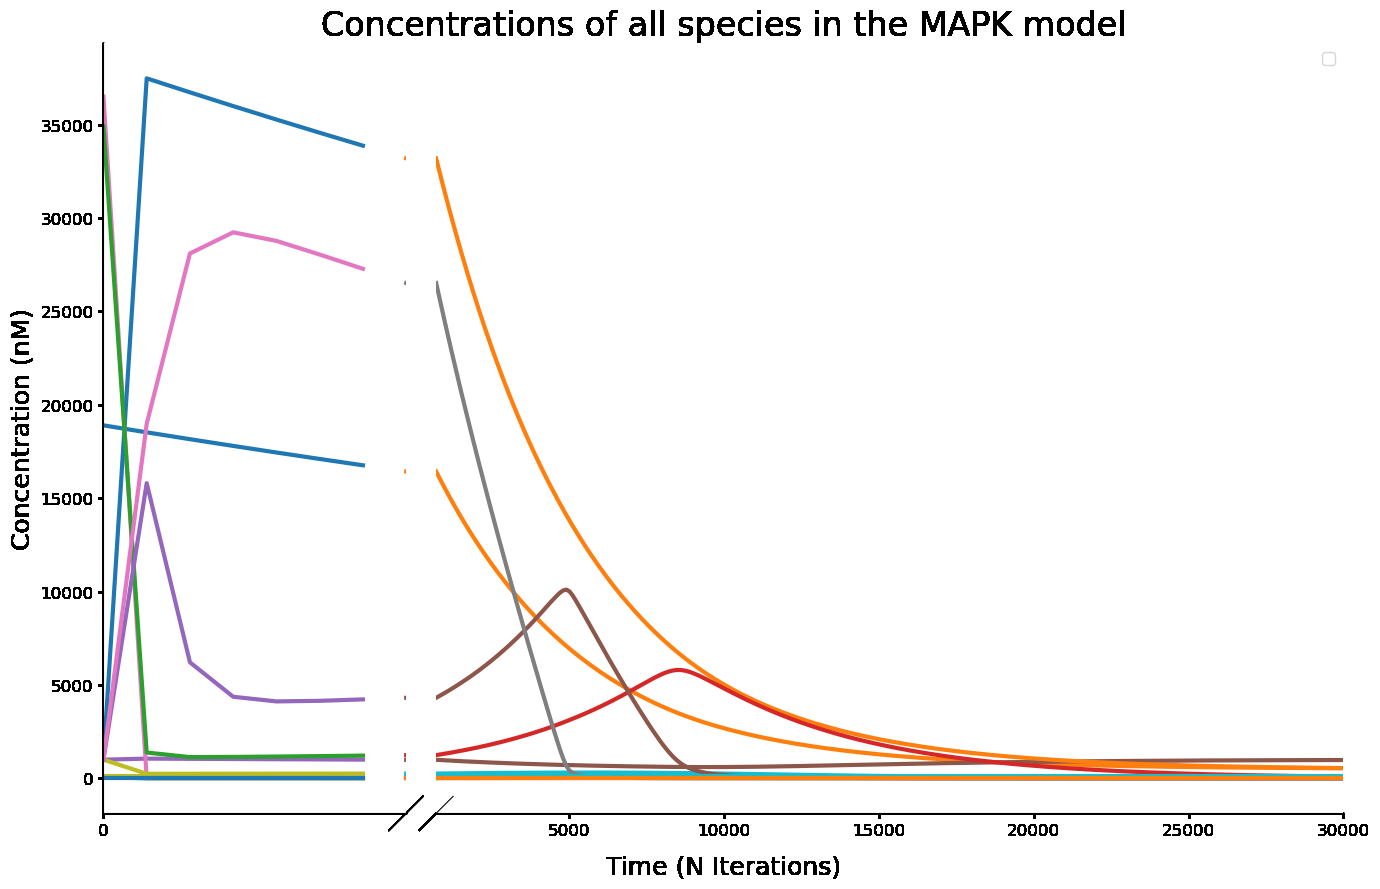

In [5]:
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes

# Plot the solution
fig = plt.figure(figsize=(10, 6))

x_axis_breakpoint = 700

def plot_concentrations(i, df_solution, species_list=species_list):
    print(dir_initial_concentrations.keys())
    print(species_list)

    bax = brokenaxes(xlims=((0, x_axis_breakpoint), (x_axis_breakpoint, 30000)), wspace = 0.05, width_ratios = (1, 3), d = 0.015, fig = fig)
    for species in species_list:
        if i == 0:
            bax.plot(df_solution.index[df_solution.index <= x_axis_breakpoint], df_solution.loc[df_solution.index <= x_axis_breakpoint, species], label = species, linewidth = 3)
            bax.plot(df_solution.index[df_solution.index > x_axis_breakpoint], df_solution.loc[df_solution.index > x_axis_breakpoint, species], linewidth = 3)
        

            #ax = plt.plot(df_solution.index, df_solution[species], label=species, linewidth=2)
        else:
            bax.plot(df_solution.index[df_solution.index <= x_axis_breakpoint], df_solution[species][df_solution.index <= x_axis_breakpoint], linewidth = 3)
            bax.plot(df_solution.index[df_solution.index > x_axis_breakpoint], df_solution[species][df_solution.index > x_axis_breakpoint], linewidth = 3)
            #ax = plt.plot(df_solution.index, df_solution[species], linewidth=3)#, ylim=[0,40000])#, thickness=2)
        #plt.xlim(0, 30000)
        #plt.xlim(0,20)
        bax.set_title("Concentrations of all species in the MAPK model", fontsize=24)
        bax.set_xlabel("Time (N Iterations)", fontsize = 18, labelpad = 30)
        bax.set_ylabel("Concentration (nM)", fontsize = 18, labelpad = 50)
        #bax.axs[0].tick_params(axis='both', which='major', labelsize=12)
        
        bax.tick_params(axis='both', which='major', labelsize=12)
        
        #plt.xticks(fontsize=12)
        #plt.yticks(fontsize=12)
    
    
    #bax.axs[0].set_xticks[0, 5, 10, 15, 20]



# We plot all of the solutions of all species in a single plot

species_list_all_changeable = ['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3']

fig = plt.figure(figsize=(16, 10))
for i, df_solution in enumerate(solutions_dfs):
    plot_concentrations(i, df_solution, species_list_all_changeable)
#plot_concentrations(df_solution)
plt.legend(fontsize=12)
plt.show()


dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3'])
['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3']
dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3'])
['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3']
dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3'])
['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3']
dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3'])
['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3']
dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3'])
['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3']
dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ER

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x600 with 0 Axes>

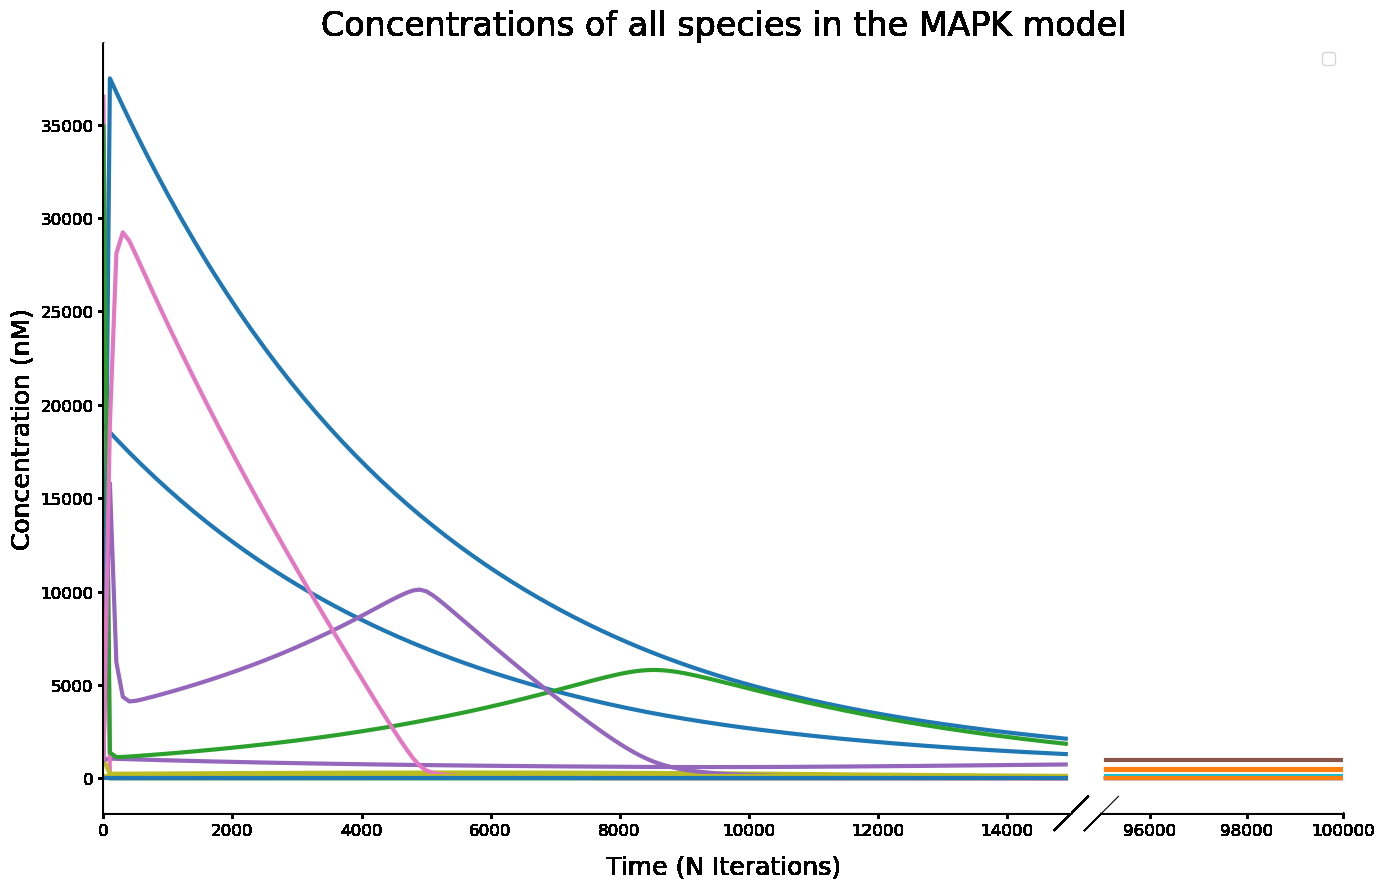

In [6]:
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes

# Plot the solution
fig = plt.figure(figsize=(10, 6))

x_axis_breakpoint_a = 15000
x_axis_breakpoint_b = 95000
x_axis_endpoint = 100000

def plot_concentrations_with_gap(i, df_solution, species_list=species_list):
    print(dir_initial_concentrations.keys())
    print(species_list)

    bax = brokenaxes(xlims=((0, x_axis_breakpoint_a), (x_axis_breakpoint_b, x_axis_endpoint)), wspace = 0.05, width_ratios = (4, 1), d = 0.015, fig = fig)
    for species in species_list:
        if i == 0:
            bax.plot(df_solution.index[df_solution.index <= x_axis_breakpoint_a], df_solution.loc[df_solution.index <= x_axis_breakpoint_a, species], label = species, linewidth = 3)
            bax.plot(df_solution.index[df_solution.index > x_axis_breakpoint_b], df_solution.loc[df_solution.index > x_axis_breakpoint_b, species], linewidth = 3)
        

            #ax = plt.plot(df_solution.index, df_solution[species], label=species, linewidth=2)
        else:
            bax.plot(df_solution.index[df_solution.index <= x_axis_breakpoint_a], df_solution[species][df_solution.index <= x_axis_breakpoint_a], linewidth = 3)
            bax.plot(df_solution.index[df_solution.index > x_axis_breakpoint_b], df_solution[species][df_solution.index > x_axis_breakpoint_b], linewidth = 3)
            #ax = plt.plot(df_solution.index, df_solution[species], linewidth=3)#, ylim=[0,40000])#, thickness=2)
        #plt.xlim(0, 30000)
        #plt.xlim(0,20)
        bax.set_title("Concentrations of all species in the MAPK model", fontsize=24)
        bax.set_xlabel("Time (N Iterations)", fontsize = 18, labelpad = 30)
        bax.set_ylabel("Concentration (nM)", fontsize = 18, labelpad = 50)
        #bax.axs[0].tick_params(axis='both', which='major', labelsize=12)
        
        bax.tick_params(axis='both', which='major', labelsize=12)
        
        #plt.xticks(fontsize=12)
        #plt.yticks(fontsize=12)
    
    
    #bax.axs[0].set_xticks[0, 5, 10, 15, 20]



# We plot all of the solutions of all species in a single plot

species_list_all_changeable = ['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3']

fig = plt.figure(figsize=(16, 10))
for i, df_solution in enumerate(solutions_dfs):
    plot_concentrations_with_gap(i, df_solution, species_list_all_changeable)
#plot_concentrations(df_solution)
plt.legend(fontsize=12)
plt.show()


dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3'])
['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3']
dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3'])
['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3']
dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3'])
['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3']
dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3'])
['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3']
dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3'])
['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3']
dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ER

<Figure size 1000x600 with 0 Axes>

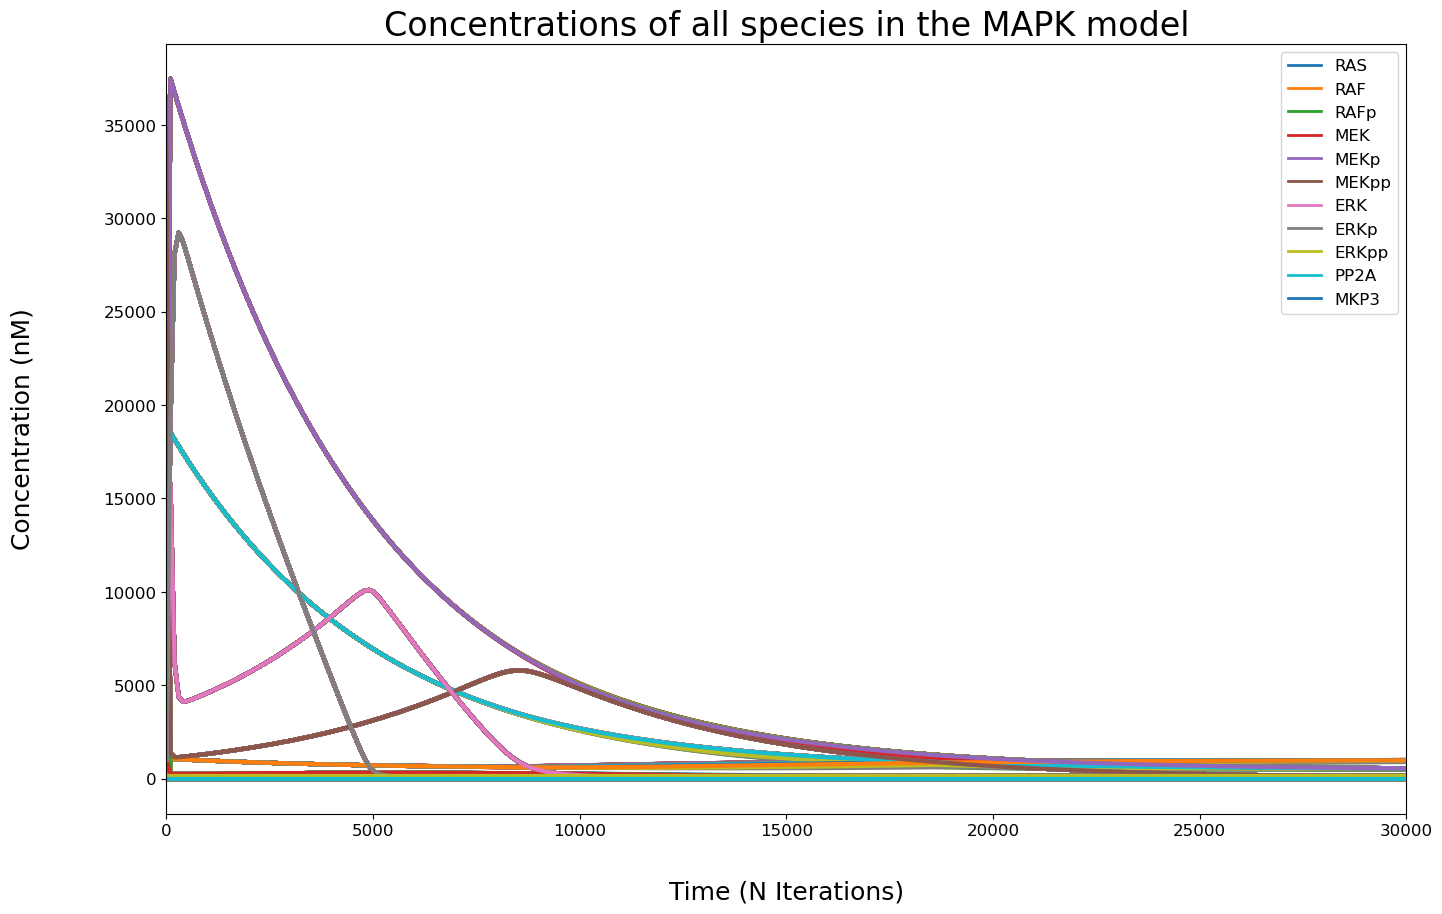

In [7]:
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes

# Plot the solution
fig = plt.figure(figsize=(10, 6))


def plot_concentrations_simple(i, df_solution, species_list=species_list):
    print(dir_initial_concentrations.keys())
    print(species_list)

    for species in species_list:
        if i == 0:
            ax = plt.plot(df_solution.index, df_solution[species], label=species, linewidth=2)
        else:
            ax = plt.plot(df_solution.index, df_solution[species], linewidth=3)#, ylim=[0,40000])#, thickness=2)
        plt.xlim(0, 30000)
        plt.title("Concentrations of all species in the MAPK model", fontsize=24)
        plt.xlabel("Time (N Iterations)", fontsize = 18, labelpad = 30)
        plt.ylabel("Concentration (nM)", fontsize = 18, labelpad = 50)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
    
    


# We plot all of the solutions of all species in a single plot

species_list_all_changeable = ['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3']

fig = plt.figure(figsize=(16, 10))
for i, df_solution in enumerate(solutions_dfs):
    plot_concentrations_simple(i, df_solution, species_list_all_changeable)
#plot_concentrations(df_solution)
plt.legend(fontsize=12)
plt.show()


dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3'])
['RAS', 'RAF', 'RAFp']
(244.09821410343795, 52.44744292557851, 837.1750239211564, 995.6267688296189, 65.26526387059776, 285.2943632866182)
dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3'])
['RAS', 'RAF', 'RAFp']
(365.9441852404875, 390.8829542064874, 928.7249693112395, 575.3419755044363, 52.25138268241702, 73.57153081609266)
dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3'])
['RAS', 'RAF', 'RAFp']
(501.7681109956149, 719.0426544808507, 209.68477189274148, 483.5200832542333, 567.3931868178594, 617.9621854040728)
dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3'])
['RAS', 'RAF', 'RAFp']
(333.2195582386067, 308.7940968268819, 389.89479819822697, 635.7590776928445, 221.2248521654366, 716.9242015626891)
dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKp

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(295.38879444364625, 285.50062175959556, 234.83648665193445, 604.7817963616858, 484.31652854621484, 301.81549419643403)
dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3'])
['RAS', 'RAF', 'RAFp']
(26.433983275103092, 599.0033536152079, 131.35706707945474, 937.3910606949445, 23.688901420700812, 246.80594332609547)
dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3'])
['RAS', 'RAF', 'RAFp']
(795.9611141120805, 703.5379860267234, 75.20534749363452, 417.11633475842325, 412.8303564676775, 681.4001750861082)


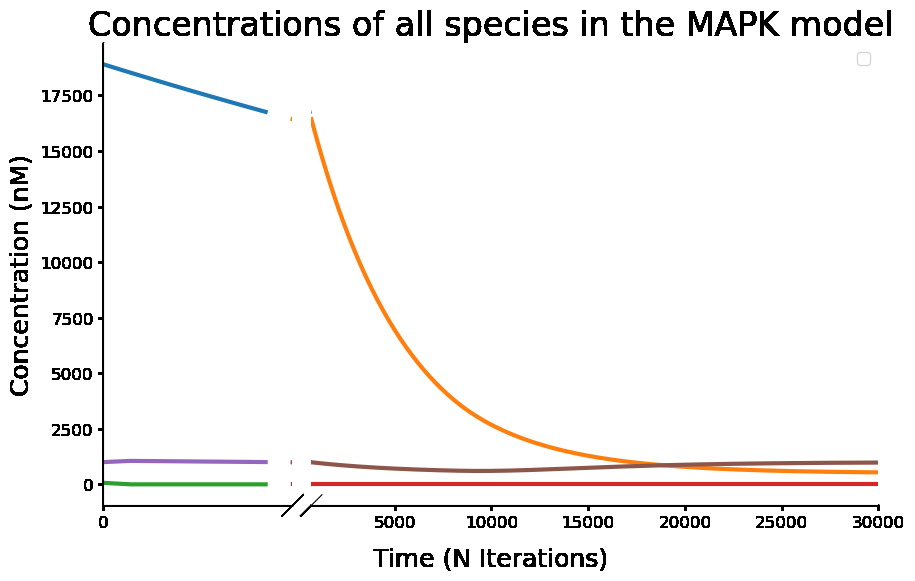

In [8]:
RAS_and_RAF = ['RAS', 'RAF', 'RAFp']

fig = plt.figure(figsize=(10, 6))
for i, df_solution in enumerate(solutions_dfs):
    plot_concentrations(i, df_solution, RAS_and_RAF)
    k_values = df_solution.attrs['k-values']
    print(k_values)
#plot_concentrations(df_solution)
plt.legend(fontsize=12)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3'])
['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp']
(251.75267763322472, 248.87804702006846, 602.0225096832719, 66.3404064082235, 786.4994886782027, 630.4057617244722)


[]

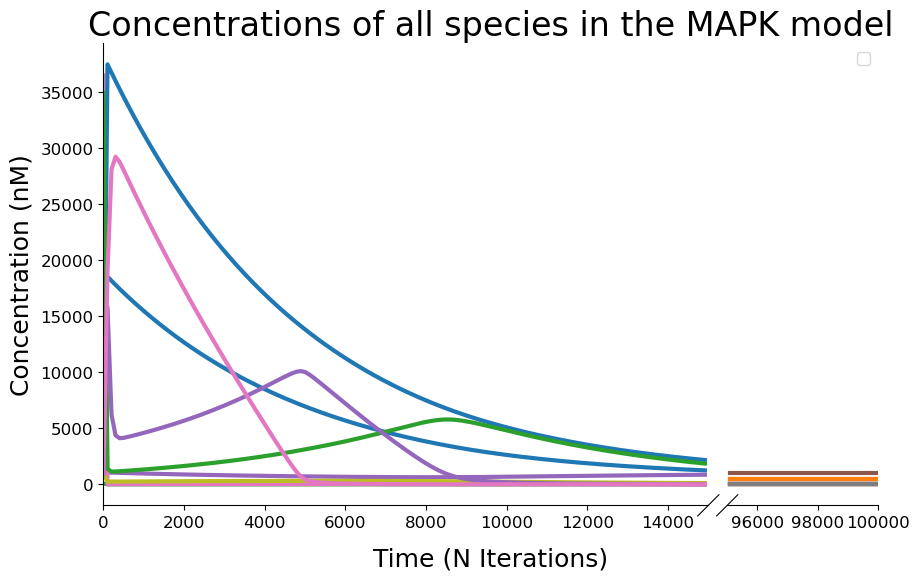

In [9]:
# We plot one of the solutions (randomly)

fig = plt.figure(figsize=(10, 6))
plot_concentrations_with_gap(0, solutions_dfs[80])
df_solution_N = solutions_dfs[80]
k_values = df_solution_N.attrs['k-values']
print(k_values)
plt.legend(fontsize=12)
#plt.xlim(0, 100000)
#plt.xlabel("Time (N Iterations)", fontsize = 18, labelpad = 5)
#plt.ylabel("Concentration (nM)", fontsize = 18, labelpad = 5)
plt.plot()

In the thesis, the next plot is used, as well as the calculations of the median values and standard deviations that are calculated here

dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3'])
['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp']
(251.75267763322472, 248.87804702006846, 602.0225096832719, 66.3404064082235, 786.4994886782027, 630.4057617244722)


,RAS,RAF,RAFp,MEK,MEKp,MEKpp,ERK,ERKp,ERKpp,PP2A,MKP3
Time,,,,,,,,,,,
0.0000,18900.000000,66.400000,1000.000000,36500.000000,1000.000000,1000.000000,34900.000000,1.000000e+03,1.000000e+03,150.0,2.4
100.1001,18525.433582,0.002999,1055.205424,13.436756,243.688338,37479.999981,1381.076779,1.580430e+04,1.898323e+04,150.0,2.4
200.2002,18158.244478,0.003060,1044.202207,13.675637,245.763044,36729.719796,1136.605823,6.212301e+03,2.810280e+04,150.0,2.4
300.3003,17798.334892,0.003122,1033.417926,13.915354,247.817240,35994.294450,1146.213074,4.367492e+03,2.923532e+04,150.0,2.4
400.4004,17445.559753,0.003185,1022.847786,14.155769,249.850536,35273.425083,1165.994124,4.118626e+03,2.877564e+04,150.0,2.4
...,...,...,...,...,...,...,...,...,...,...,...
99599.5996,500.000027,0.111334,999.888657,2.055502,28.380051,469.564525,0.000084,1.493082e-07,3.095608e-11,150.0,2.4
99699.6997,500.000027,0.111334,999.888657,2.055502,28.380051,469.564524,0.000082,1.463565e-07,3.031190e-11,150.0,2.4
99799.7998,500.000026,0.111334,999.888658,2.055502,28.380051,469.564522,0.000080,1.434631e-07,2.966890e-11,150.0,2.4


RAS      500.000
RAF        0.111
RAFp     999.889
MEK        2.056
MEKp      28.380
MEKpp    469.565
ERK        0.000
ERKp       0.000
ERKpp      0.000
PP2A     150.000
MKP3       2.400
Name: 100000.0, dtype: float64
The median final value of RAS is: 500.00003 and the standard deviation is: 0.0
The median final value of RAF is: 0.11133 and the standard deviation is: 0.0
The median final value of RAFp is: 999.88866 and the standard deviation is: 0.0
The median final value of MEK is: 2.0555 and the standard deviation is: 0.0
The median final value of MEKp is: 28.38005 and the standard deviation is: 0.0
The median final value of MEKpp is: 469.56452 and the standard deviation is: 0.0
The median final value of ERK is: 8e-05 and the standard deviation is: 0.0
The median final value of ERKp is: 0.0 and the standard deviation is: 0.0
The median final value of ERKpp is: 0.0 and the standard deviation is: 0.0
The median final value of PP2A is: 150.0 and the standard deviation is: 0.0
The median

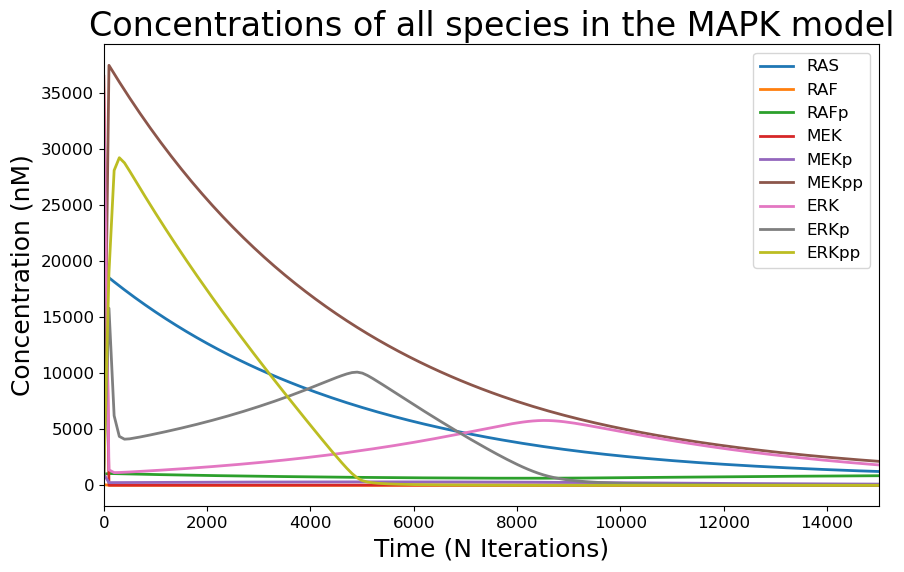

In [10]:
"""This plot has correct colors in the legend, the above plots not"""

# We plot one of the solutions (randomly)

fig = plt.figure(figsize=(10, 6))
plot_concentrations_simple(0, solutions_dfs[80])
df_solution_N = solutions_dfs[80]
k_values = df_solution_N.attrs['k-values']
print(k_values)
plt.legend(fontsize=12)
plt.xlim(0, 15000)
plt.xlabel("Time (N Iterations)", fontsize = 18, labelpad = 5)
plt.ylabel("Concentration (nM)", fontsize = 18, labelpad = 5)
plt.plot()

this_df = solutions_dfs[80]
display(this_df)
final_values = this_df.loc[100000, :]
final_values_rounded = np.round(final_values, decimals = 3)
print(final_values_rounded)
#print("The solution is: {}".format(solutions_dfs[80].loc[:, -5:]))

#print(df_solution_N.loc[80,-1:])

# Now we will calculate the final values of each species for each solution (as we did above for 1 solution) and then calculate the average (median) and standard deviation of all final values for each species

dict_final_values = {}

for df_sol in solutions_dfs:
    final_values = df_sol.loc[100000, :]
    dict_final_values[df_sol.attrs['k-values']] = final_values

# Now we calculate the meidan final value of all species
for species in species_list_all_changeable:
    species_final_values = []
    for k_values, final_values in dict_final_values.items():
        species_final_values.append(final_values[species])
    median_final_value = np.median(species_final_values)
    median_final_value_rounded = np.round(median_final_value, decimals = 5)
    std_final_value = np.std(species_final_values)
    std_final_value_rounded = np.round(std_final_value, decimals = 3)
    print(f"The median final value of {species} is: {median_final_value_rounded} and the standard deviation is: {std_final_value_rounded}")



dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3'])
['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp']
(251.75267763322472, 248.87804702006846, 602.0225096832719, 66.3404064082235, 786.4994886782027, 630.4057617244722)


[]

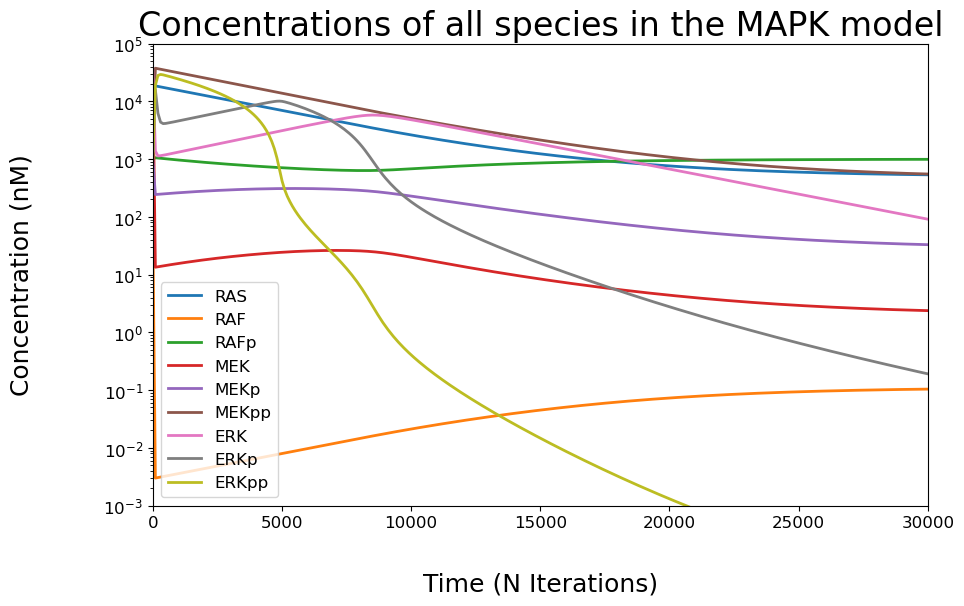

In [12]:
# We plot one of the solutions (randomly) with a log scale on the y-axis

fig = plt.figure(figsize=(10, 6))
plot_concentrations_simple(0, solutions_dfs[80])
df_solution_N = solutions_dfs[80]
k_values = df_solution_N.attrs['k-values']
print(k_values)
plt.legend(fontsize=12)
plt.yscale("log")
plt.ylim(0.001, 100000)
plt.plot()

In [19]:
display((solutions_dfs[0]))
display((solutions_dfs[1]))
display(solutions_dfs[2])
display(solutions_dfs[3])

for i in range(0, 5):
    display(solutions_dfs[i].iloc[600:609])

,RAS,RAF,RAFp,MEK,MEKp,MEKpp,ERK,ERKp,ERKpp,PP2A,MKP3
Time,,,,,,,,,,,
0.0000,18900.000000,66.400000,1000.000000,36500.000000,1000.000000,1000.000000,34900.000000,1.000000e+03,1.000000e+03,150.0,2.4
100.1001,18525.397072,0.002999,1055.474131,13.430258,243.625442,37479.853081,1381.116254,1.580406e+04,1.898343e+04,150.0,2.4
200.2002,18158.206636,0.003060,1044.495435,13.668244,245.692727,36729.567210,1136.585472,6.212315e+03,2.810281e+04,150.0,2.4
300.3003,17798.294567,0.003122,1033.750349,13.906690,247.735970,35994.131075,1146.154620,4.368499e+03,2.923437e+04,150.0,2.4
400.4004,17445.516447,0.003185,1023.225367,14.145698,249.756633,35273.249012,1166.054065,4.122567e+03,2.877164e+04,150.0,2.4
...,...,...,...,...,...,...,...,...,...,...,...
99599.5996,500.000027,0.111334,999.888659,2.055502,28.380050,469.564500,0.000083,1.489951e-07,3.060476e-11,150.0,2.4
99699.6997,500.000027,0.111334,999.888659,2.055502,28.380050,469.564499,0.000082,1.460423e-07,2.999909e-11,150.0,2.4
99799.7998,500.000026,0.111334,999.888659,2.055502,28.380050,469.564498,0.000080,1.431482e-07,2.940554e-11,150.0,2.4


,RAS,RAF,RAFp,MEK,MEKp,MEKpp,ERK,ERKp,ERKpp,PP2A,MKP3
Time,,,,,,,,,,,
0.0000,18900.000000,66.400000,1000.000000,36500.000000,1000.000000,1000.000000,34900.000000,1.000000e+03,1.000000e+03,150.0,2.4
100.1001,18525.477766,0.002999,1055.420217,13.431506,243.637805,37479.828234,1381.107718,1.580414e+04,1.898336e+04,150.0,2.4
200.2002,18158.291005,0.003060,1044.431443,13.669760,245.707692,36729.539094,1136.616075,6.212301e+03,2.810279e+04,150.0,2.4
300.3003,17798.385476,0.003122,1033.670546,13.908631,247.754850,35994.097858,1146.228699,4.367444e+03,2.923535e+04,150.0,2.4
400.4004,17445.615128,0.003185,1023.127464,14.148149,249.780215,35273.209647,1165.998788,4.118657e+03,2.877561e+04,150.0,2.4
...,...,...,...,...,...,...,...,...,...,...,...
99599.5996,500.000030,0.111334,999.888659,2.055502,28.380049,469.564494,0.000084,1.492317e-07,3.065711e-11,150.0,2.4
99699.6997,500.000030,0.111334,999.888659,2.055502,28.380049,469.564493,0.000082,1.462621e-07,3.004708e-11,150.0,2.4
99799.7998,500.000029,0.111334,999.888659,2.055502,28.380049,469.564492,0.000080,1.433533e-07,2.944955e-11,150.0,2.4


,RAS,RAF,RAFp,MEK,MEKp,MEKpp,ERK,ERKp,ERKpp,PP2A,MKP3
Time,,,,,,,,,,,
0.0000,18900.000000,66.400000,1000.000000,36500.000000,1000.000000,1000.000000,34900.000000,1.000000e+03,1.000000e+03,150.0,2.4
100.1001,18525.557472,0.002999,1055.235564,13.435987,243.681129,37479.953457,1381.082136,1.580428e+04,1.898325e+04,150.0,2.4
200.2002,18158.377576,0.003060,1044.234321,13.674766,245.755126,36729.669898,1136.608036,6.212307e+03,2.810280e+04,150.0,2.4
300.3003,17798.483292,0.003122,1033.453546,13.914348,247.808244,35994.239307,1146.216251,4.367489e+03,2.923532e+04,150.0,2.4
400.4004,17445.726026,0.003185,1022.887593,14.154623,249.840315,35273.363953,1165.995841,4.118634e+03,2.877564e+04,150.0,2.4
...,...,...,...,...,...,...,...,...,...,...,...
99599.5996,500.000031,0.111334,999.888651,2.055502,28.380051,469.564522,0.000082,1.464300e-07,3.008244e-11,150.0,2.4
99699.6997,500.000031,0.111334,999.888651,2.055502,28.380051,469.564521,0.000080,1.435342e-07,2.948749e-11,150.0,2.4
99799.7998,500.000030,0.111334,999.888651,2.055502,28.380051,469.564519,0.000079,1.406975e-07,2.890469e-11,150.0,2.4


,RAS,RAF,RAFp,MEK,MEKp,MEKpp,ERK,ERKp,ERKpp,PP2A,MKP3
Time,,,,,,,,,,,
0.0000,18900.000000,66.400000,1000.000000,36500.000000,1000.000000,1000.000000,34900.000000,1.000000e+03,1.000000e+03,150.0,2.4
100.1001,18525.457981,0.002999,1055.302000,13.434346,243.665438,37479.878588,1381.096510,1.580423e+04,1.898328e+04,150.0,2.4
200.2002,18158.270010,0.003060,1044.305211,13.672921,245.737908,36729.591240,1136.612412,6.212312e+03,2.810279e+04,150.0,2.4
300.3003,17798.362416,0.003122,1033.531926,13.912226,247.788760,35994.154121,1146.222872,4.367471e+03,2.923533e+04,150.0,2.4
400.4004,17445.589637,0.003185,1022.974748,14.152211,249.818269,35273.271095,1165.997926,4.118647e+03,2.877562e+04,150.0,2.4
...,...,...,...,...,...,...,...,...,...,...,...
99599.5996,500.000029,0.111334,999.888655,2.055502,28.380051,469.564518,0.000083,1.485132e-07,3.050862e-11,150.0,2.4
99699.6997,500.000029,0.111334,999.888656,2.055502,28.380051,469.564516,0.000082,1.455805e-07,2.990602e-11,150.0,2.4
99799.7998,500.000028,0.111334,999.888656,2.055502,28.380051,469.564515,0.000080,1.427035e-07,2.931490e-11,150.0,2.4


,RAS,RAF,RAFp,MEK,MEKp,MEKpp,ERK,ERKp,ERKpp,PP2A,MKP3
Time,,,,,,,,,,,
60060.060060,500.078942,0.111316,999.870638,2.056113,28.388698,469.716029,0.222336,0.000397,8.163273e-08,150.0,2.4
60160.160160,500.077358,0.111316,999.870992,2.056100,28.388524,469.712960,0.217919,0.000389,8.000995e-08,150.0,2.4
60260.260260,500.075805,0.111317,999.871338,2.056088,28.388352,469.709955,0.213591,0.000382,7.841970e-08,150.0,2.4
60360.360360,500.074284,0.111317,999.871678,2.056077,28.388185,469.707010,0.209350,0.000374,7.686141e-08,150.0,2.4
60460.460460,500.072795,0.111317,999.872010,2.056065,28.388020,469.704127,0.205194,0.000367,7.533455e-08,150.0,2.4
60560.560561,500.071335,0.111318,999.872337,2.056054,28.387859,469.701302,0.201122,0.000359,7.383862e-08,150.0,2.4
60660.660661,500.069906,0.111318,999.872656,2.056043,28.387702,469.698536,0.197132,0.000352,7.237312e-08,150.0,2.4
60760.760761,500.068506,0.111318,999.872970,2.056032,28.387547,469.695828,0.193224,0.000345,7.093759e-08,150.0,2.4
60860.860861,500.067135,0.111319,999.873277,2.056021,28.387396,469.693176,0.189396,0.000338,6.953158e-08,150.0,2.4


,RAS,RAF,RAFp,MEK,MEKp,MEKpp,ERK,ERKp,ERKpp,PP2A,MKP3
Time,,,,,,,,,,,
60060.060060,500.084638,0.111315,999.871358,2.056073,28.388119,469.705645,0.221757,0.000396,8.141060e-08,150.0,2.4
60160.160160,500.082945,0.111315,999.871697,2.056061,28.387955,469.702766,0.217349,0.000388,7.979129e-08,150.0,2.4
60260.260260,500.081285,0.111316,999.872030,2.056050,28.387794,469.699947,0.213029,0.000381,7.820424e-08,150.0,2.4
60360.360360,500.079659,0.111316,999.872357,2.056039,28.387637,469.697185,0.208795,0.000373,7.664886e-08,150.0,2.4
60460.460460,500.078066,0.111316,999.872677,2.056028,28.387482,469.694480,0.204645,0.000366,7.512458e-08,150.0,2.4
60560.560561,500.076505,0.111317,999.872991,2.056017,28.387331,469.691830,0.200578,0.000358,7.363085e-08,150.0,2.4
60660.660661,500.074975,0.111317,999.873299,2.056007,28.387183,469.689235,0.196593,0.000351,7.216713e-08,150.0,2.4
60760.760761,500.073476,0.111317,999.873600,2.055996,28.387038,469.686693,0.192688,0.000344,7.073292e-08,150.0,2.4
60860.860861,500.072008,0.111318,999.873896,2.055986,28.386896,469.684204,0.188862,0.000337,6.932773e-08,150.0,2.4


,RAS,RAF,RAFp,MEK,MEKp,MEKpp,ERK,ERKp,ERKpp,PP2A,MKP3
Time,,,,,,,,,,,
60060.060060,500.088976,0.111314,999.853727,2.056343,28.391635,469.761705,0.224624,0.000401,8.248258e-08,150.0,2.4
60160.160160,500.087210,0.111314,999.854399,2.056327,28.391406,469.757799,0.220184,0.000393,8.085076e-08,150.0,2.4
60260.260260,500.085478,0.111315,999.855059,2.056310,28.391182,469.753970,0.215831,0.000386,7.925136e-08,150.0,2.4
60360.360360,500.083781,0.111315,999.855705,2.056295,28.390962,469.750217,0.211565,0.000378,7.768371e-08,150.0,2.4
60460.460460,500.082118,0.111315,999.856339,2.056279,28.390746,469.746539,0.207384,0.000371,7.614716e-08,150.0,2.4
60560.560561,500.080488,0.111316,999.856961,2.056264,28.390535,469.742934,0.203285,0.000363,7.464107e-08,150.0,2.4
60660.660661,500.078890,0.111316,999.857571,2.056249,28.390328,469.739400,0.199267,0.000356,7.316479e-08,150.0,2.4
60760.760761,500.077324,0.111316,999.858170,2.056234,28.390124,469.735936,0.195329,0.000349,7.171769e-08,150.0,2.4
60860.860861,500.075789,0.111317,999.858756,2.056219,28.389925,469.732540,0.191468,0.000342,7.029915e-08,150.0,2.4


,RAS,RAF,RAFp,MEK,MEKp,MEKpp,ERK,ERKp,ERKpp,PP2A,MKP3
Time,,,,,,,,,,,
60060.060060,500.083205,0.111315,999.863472,2.056256,28.390629,469.748144,0.221838,0.000396,8.145853e-08,150.0,2.4
60160.160160,500.081539,0.111316,999.863962,2.056241,28.390418,469.744476,0.217428,0.000388,7.983810e-08,150.0,2.4
60260.260260,500.079907,0.111316,999.864443,2.056227,28.390211,469.740881,0.213107,0.000381,7.825032e-08,150.0,2.4
60360.360360,500.078308,0.111316,999.864915,2.056212,28.390009,469.737360,0.208874,0.000373,7.669469e-08,150.0,2.4
60460.460460,500.076742,0.111317,999.865377,2.056198,28.389810,469.733910,0.204726,0.000366,7.517072e-08,150.0,2.4
60560.560561,500.075208,0.111317,999.865830,2.056184,28.389616,469.730531,0.200663,0.000358,7.367793e-08,150.0,2.4
60660.660661,500.073706,0.111317,999.866274,2.056171,28.389426,469.727222,0.196684,0.000351,7.221588e-08,150.0,2.4
60760.760761,500.072235,0.111318,999.866709,2.056157,28.389239,469.723982,0.192786,0.000344,7.078415e-08,150.0,2.4
60860.860861,500.070795,0.111318,999.867135,2.056144,28.389057,469.720809,0.188970,0.000338,6.938234e-08,150.0,2.4


,RAS,RAF,RAFp,MEK,MEKp,MEKpp,ERK,ERKp,ERKpp,PP2A,MKP3
Time,,,,,,,,,,,
60060.060060,500.086624,0.111314,999.858411,2.056250,28.390374,469.740722,0.221834,0.000396,8.145313e-08,150.0,2.4
60160.160160,500.084892,0.111315,999.858998,2.056235,28.390167,469.737190,0.217422,0.000388,7.983171e-08,150.0,2.4
60260.260260,500.083195,0.111315,999.859573,2.056220,28.389965,469.733730,0.213098,0.000381,7.824301e-08,150.0,2.4
60360.360360,500.081532,0.111316,999.860138,2.056206,28.389767,469.730341,0.208862,0.000373,7.668652e-08,150.0,2.4
60460.460460,500.079904,0.111316,999.860691,2.056192,28.389573,469.727021,0.204712,0.000366,7.516175e-08,150.0,2.4
60560.560561,500.078309,0.111316,999.861233,2.056178,28.389383,469.723770,0.200647,0.000358,7.366824e-08,150.0,2.4
60660.660661,500.076747,0.111317,999.861764,2.056165,28.389197,469.720586,0.196665,0.000351,7.220553e-08,150.0,2.4
60760.760761,500.075218,0.111317,999.862285,2.056151,28.389015,469.717468,0.192766,0.000344,7.077320e-08,150.0,2.4
60860.860861,500.073720,0.111317,999.862795,2.056139,28.388836,469.714416,0.188949,0.000338,6.937087e-08,150.0,2.4


In [20]:
# For one of the species, we plot all solutions in a single plot

def plot_concentration_single_species(df_solution, species):
    ax = plt.plot(df_solution.index, df_solution[species], label=species, linewidth=1)#, ylim=[0,40000])#, thickness=2)
    plt.xlim(0, 15000)
    plt.title("Concentrations of all species in the MAPK model", fontsize=24)
    plt.xlabel("Time (N Iterations)", fontsize=18)
    plt.ylabel("Concentration (nM)", fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)

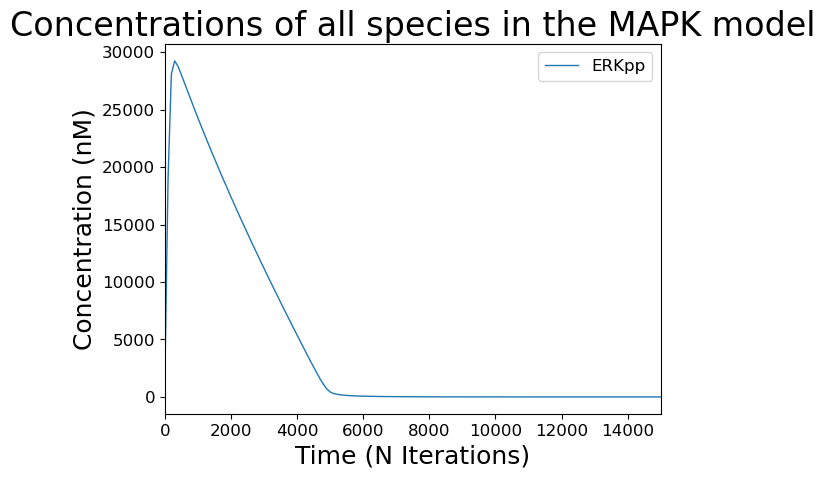

In [15]:
plot_concentration_single_species(solutions_dfs[0], "ERKpp")

In [21]:
print(unique_steady_states)
type(unique_steady_states)
print(len(unique_steady_states))
print(unique_steady_states[1])

[[4.9999986e+02 1.1133000e-01 9.9988865e+02 2.0555000e+00 2.8380050e+01
  4.6956452e+02 8.0000000e-05 0.0000000e+00 0.0000000e+00 1.5000000e+02
  2.4000000e+00]
 [4.9999990e+02 1.1133000e-01 9.9988866e+02 2.0555000e+00 2.8380050e+01
  4.6956452e+02 8.0000000e-05 0.0000000e+00 0.0000000e+00 1.5000000e+02
  2.4000000e+00]
 [4.9999997e+02 1.1133000e-01 9.9988865e+02 2.0555000e+00 2.8380050e+01
  4.6956446e+02 8.0000000e-05 0.0000000e+00 0.0000000e+00 1.5000000e+02
  2.4000000e+00]
 [4.9999999e+02 1.1133000e-01 9.9988866e+02 2.0555000e+00 2.8380050e+01
  4.6956452e+02 8.0000000e-05 0.0000000e+00 0.0000000e+00 1.5000000e+02
  2.4000000e+00]
 [5.0000000e+02 1.1133000e-01 9.9988865e+02 2.0555000e+00 2.8380050e+01
  4.6956449e+02 8.0000000e-05 0.0000000e+00 0.0000000e+00 1.5000000e+02
  2.4000000e+00]
 [5.0000000e+02 1.1133000e-01 9.9988866e+02 2.0555000e+00 2.8380050e+01
  4.6956452e+02 8.0000000e-05 0.0000000e+00 0.0000000e+00 1.5000000e+02
  2.4000000e+00]
 [5.0000001e+02 1.1133000e-01 9.99

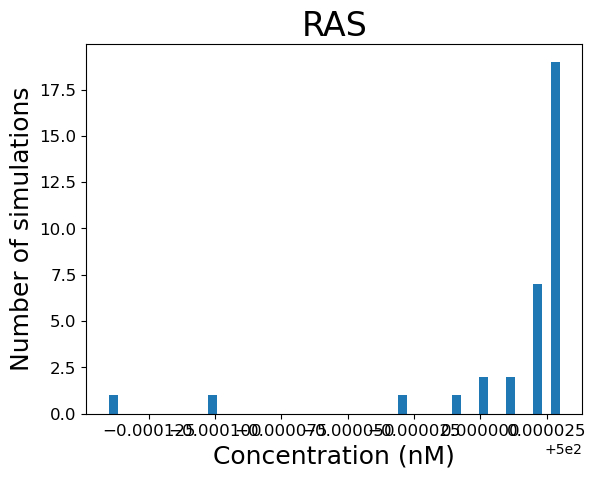

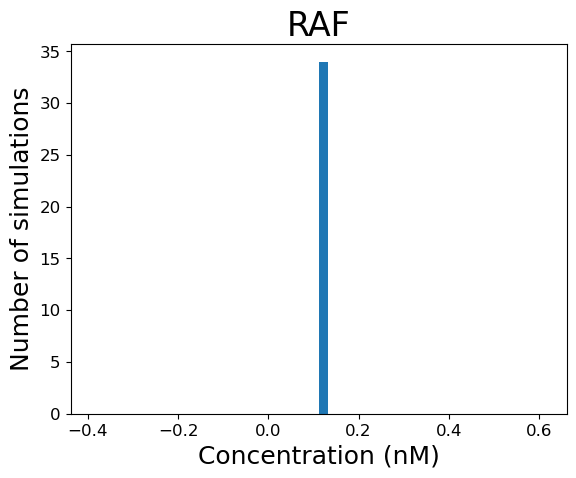

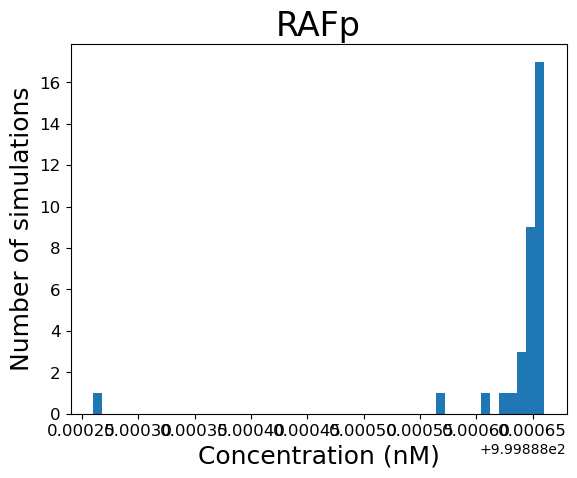

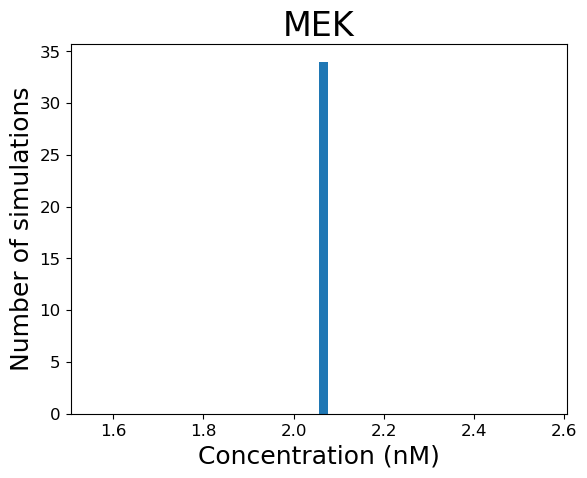

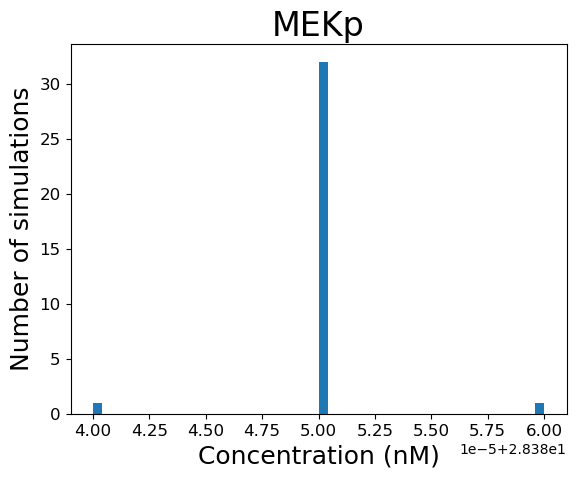

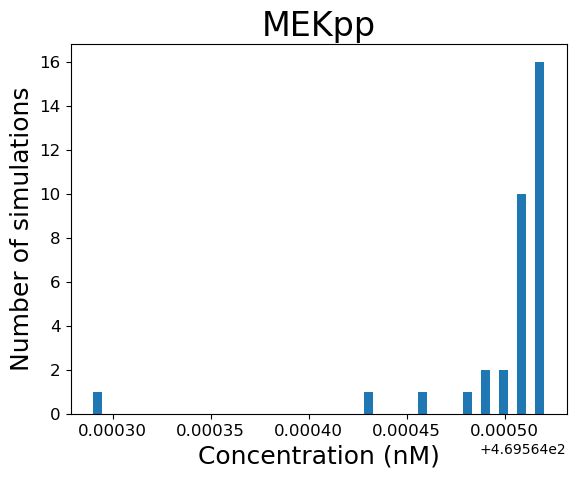

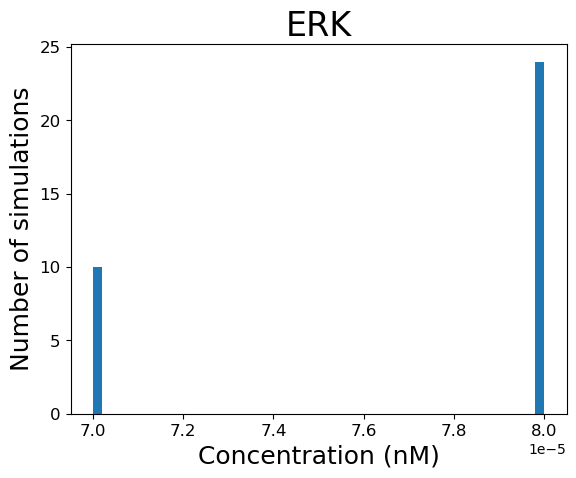

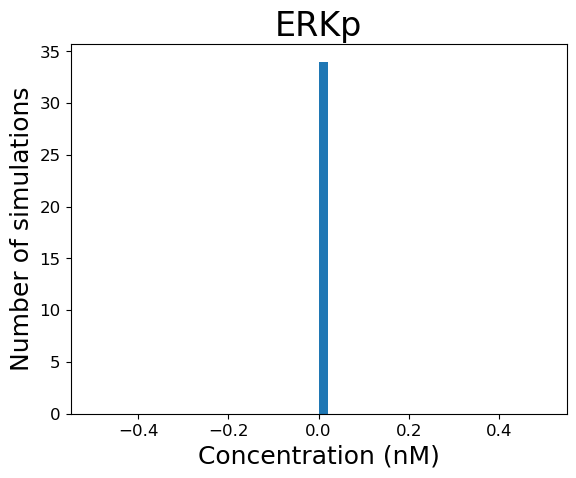

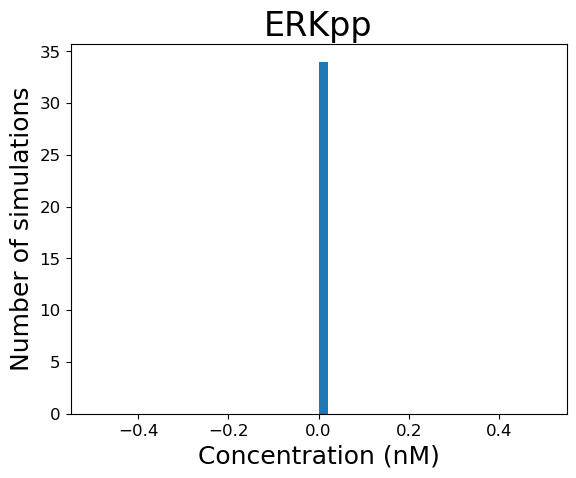

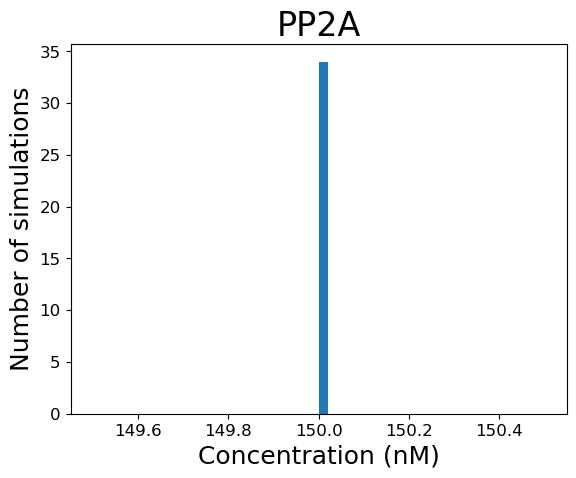

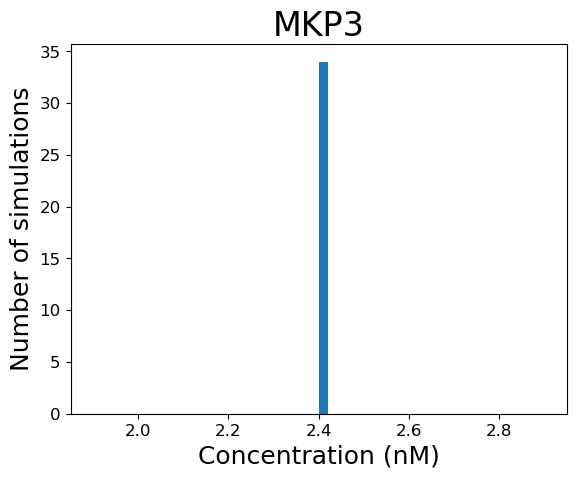

In [22]:
import matplotlib.pyplot as plt

for species in dir_initial_concentrations.keys():
    plt.figure()
    plt.hist(unique_steady_states[:, list(dir_initial_concentrations.keys()).index(species)], bins=50)
    plt.title(species, fontsize=24)
    plt.xlabel("Concentration (nM)", fontsize=18)
    plt.ylabel("Number of simulations", fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
#plt.hist(unique_steady_states[:, 5], bins=50)

